## Read MESAN files
Streamlined method to readably load several MESAN csv data into one dataframe. Select station id and time interval. Returns dataframe containing all data for specifed station between start_date and end_date.

- Deals with missing files/directories.
- Returned dataframe is chronologically sorted.

In [124]:
import os
import datetime
import pandas as pd


# My suggested solution to read MESAN csvs.
# @params id: station id (string)
#         start_date: date object. Includes this date when reading.
#                     example: datetime.date(2020, 9, 1)
#         end_date: date object. Includes this date when reading.
# @returns comb_df: concatenated dataframe containing all csv data
#                   chronologically. None if a file was not found.
def read_MESAN(id, start_date, end_date):
    station_dir = 'METCOMP_CSV/' + id + '/'
    
    # Check if dir exists.
    if not os.path.isdir(station_dir):
        print('read_MESAN() >>> No directory: ' + station_dir)
    
    # Loop over days
    current_date = start_date
    frames = []
    for n in range(0, (end_date - start_date + datetime.timedelta(days=1)).days):
        date_str = current_date.strftime('%Y-%m-%d')
        current_file = 'MESAN_' + date_str + '.csv'
        
        # Try to read file, if file not found, return a None object.
        try:
            frames.append(pd.read_csv(station_dir + current_file))
        except IOError as e:
            print('read_MESAN() >>> File not found. (' + current_file + ')')
            return None
        
        current_date = current_date + datetime.timedelta(days=1)
    comb_df = pd.concat(frames, ignore_index=True)
    return comb_df

## Fetch data from LANTMET
This way we can get LANTMET data in dataframes. Select a station id and time interval.
The function returns a complete dataframe stretching from 00:00:00 at start_date to 23:00:00 at end_date.

- Deals with bad requests.
- Fills any missing timestamps with None objects to ensure continuity between rows.
- Chronologically sorted dataframe.

In [125]:
import requests
import datetime
import pandas as pd

def get_LANTMET(id, start_date, end_date):
    start_str = start_date.strftime('%Y-%m-%d')
    end_str = end_date.strftime('%Y-%m-%d')
    url = 'https://www.ffe.slu.se/lm/json/DownloadJS.cfm?weatherStationID=' + id + '&startDate=' + start_str + '&endDate=' + end_str
    
    # Try accessing API.
    try:
        r = requests.get(url)
    except requests.exceptions.RequestException as e:
        # If accessing API fails
        print('get_LANTMET() >>> Request failed.\n' + str(e.__str__()))
        return None

    # If data is not in JSON format, return.
    try:
        data = r.json()
    except json.JSONDecodeError:
        print('get_LANTMET() >>> Fetched data is not in JSON format.')
        print(r.text)
        return None
    
    # Init dict timestamp keys.
    tmp_dict = {}
    for e in data:
        tmp_dict[e['timeMeasured']] = {'Timestamp': e['timeMeasured'].split('+')[0] + 'Z'}
    
    # Add parameter values.
    params = {}
    for e in data:
        tmp_dict[e['timeMeasured']][e['elementMeasurementTypeId']] = e['value']
        params[e['elementMeasurementTypeId']] = None
    
    # Check if any timestamps are missing, if so fill with None values for each parameter.
    # This also ensures chonologically sorting.
    sorted_data = []
    current_dt = start_date
    for n in range(0, (end_date - start_date + datetime.timedelta(days=1)).days):
        
        for i in range(0, 24):
            # Get string representation of hour.
            hour_str = ''
            if i < 10:
                hour_str = '0' + str(i)
            else:
                hour_str = str(i)
                
            datetime_str = current_dt.strftime('%Y-%m-%d') + 'T' + hour_str + ':00:00'
            # Deal with missing timestamps in fetched data.
            try:
                # Append subdicts to list.
                sorted_data.append(tmp_dict[datetime_str + '+01:00'])
            except KeyError:
                # Timestamp not found in dict. Add one with None values for each param.
                print('Missing data for ' + datetime_str + '.')
                tmp = {}
                tmp['Timestamp'] = datetime_str + 'Z'
                for param in params:
                    tmp[param] = None
                sorted_data.append(tmp)
        current_dt = current_dt + datetime.timedelta(days=1)
        
    res_df = pd.DataFrame(sorted_data)
    return res_df

## Demonstration
- Fetch data for first seven days of September 2020 from LANTMET.
- Load corresponding MESAN data extracted from archived GRIB-files.
- Plot some data.

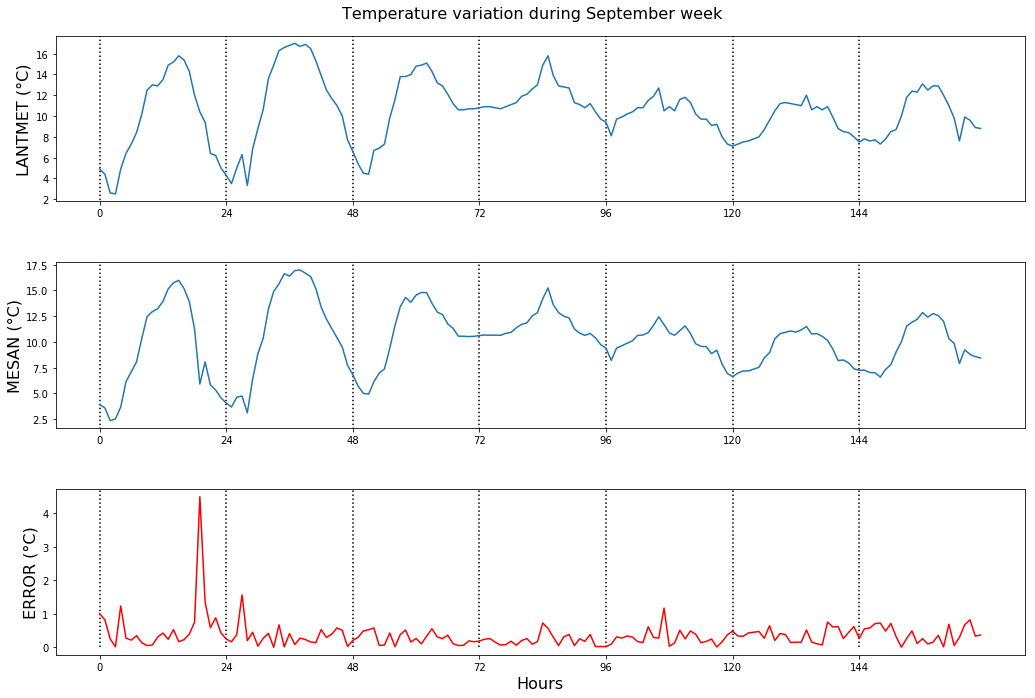

In [161]:
# Example
import matplotlib.pyplot as plt
import numpy as np

# Select station and time interval.
station = '149'
start_date = datetime.date(2020, 9, 1)
end_date = datetime.date(2020, 9, 7)

# Load data.
df_LANTMET = get_LANTMET(station, start_date, end_date)
df_MESAN = read_MESAN(station, start_date, end_date)

# Plot individual data and error.
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle('Temperature variation during September week', fontsize=16)
fig.tight_layout(pad=4.0)

hours = [int(x) for x in range(0, df_LANTMET.shape[0])]
# LANTMET DATA
axs[0].plot(hours, df_LANTMET['TM'])
axs[0].xaxis.set_ticks(np.arange(min(hours), max(hours)+1, 24.0))
axs[0].set_ylabel('LANTMET (°C)', fontsize=16)
axs[0].set_autoscale_on(False)
axs[0].vlines(np.arange(min(hours), max(hours)+1, 24.0), 0, 20, linestyles='dotted')

# MESAN DATA
axs[1].plot(hours, df_MESAN['t_sfc'] - 273.15)
axs[1].xaxis.set_ticks(np.arange(min(hours), max(hours)+1, 24.0))
axs[1].set_ylabel('MESAN (°C)', fontsize=16)
axs[1].set_autoscale_on(False)
axs[1].vlines(np.arange(min(hours), max(hours)+1, 24.0), 0, 20, linestyles='dotted')

# ABSOLUTE ERROR
axs[2].plot(hours, abs((df_MESAN['t_sfc'] - 273.15) - df_LANTMET['TM']), 'r')
axs[2].xaxis.set_ticks(np.arange(min(hours), max(hours)+1, 24.0))
axs[2].set_ylabel('ERROR (°C)', fontsize=16)
axs[2].set_autoscale_on(False)
axs[2].vlines(np.arange(min(hours), max(hours)+1, 24.0), 0, 20, linestyles='dotted')
axs[2].set_xlabel('Hours', fontsize=16);